# Welcome to Word2Vec with The Simpsons

This notebook is an updated and fully compatible version of [Gensim Word2Vec Tutorial](https://www.kaggle.com/code/pierremegret/gensim-word2vec-tutorial) by Pierre Megret, adapted to run smoothly with the libraries available in 2025.

Ever wondered what would happen if you trained a word embedding model on the wise (and not-so-wise) words of Homer Simpson? You're in the right place.

---

## What is Word2Vec?

Word2Vec is a technique used in Natural Language Processing (NLP) to transform words into continuous vector space representations. Words with similar meanings tend to appear closer together in this space. Instead of treating words as discrete tokens, Word2Vec captures relationships, analogies, and context.

For example:
- `"king" - "man" + "woman"` results in `"queen"`
- `"donut"` might be close to `"delicious"`, `"sweet"`, or `"Homer"`

In this notebook, we’ll train a Word2Vec model using dialogue from *The Simpsons*, and explore how different characters use language, what kind of vocabulary appears frequently, and visualize word relationships.

Let’s get started!


## 0. Environment Setup

Before running this notebook, make sure all required Python packages are installed.

You can install them using the `requirements.txt` file included in this project:

```bash
pip install -r requirements.txt
```

If you prefer using the latest package versions, you may remove the specific version numbers in the requirements.txt file. However, if you encounter any compatibility or runtime errors, we recommend reverting to the exact versions originally specified to ensure reproducibility.

### Import Required Libraries

To begin, we’ll import the core libraries needed for data manipulation, preprocessing, training, and visualization.


In [1]:
# Core libraries
import os
import re
from time import time
from collections import defaultdict

# Data handling
import pandas as pd

# NLP preprocessing
import spacy

# For accessing datasets via Kaggle API
import kaggle

## 1. Download Dataset

The dataset used in this notebook is publicly available on Kaggle:  
[Dialogue Lines of The Simpsons](https://www.kaggle.com/datasets/pierremegret/dialogue-lines-of-the-simpsons)

The following code uses the Kaggle API to download and unzip the dataset.  

In [2]:
import os

# Download and unzip the dataset using Kaggle API
os.system("kaggle datasets download -d pierremegret/dialogue-lines-of-the-simpsons --unzip")

# List the extracted files
os.listdir()


Dataset URL: https://www.kaggle.com/datasets/pierremegret/dialogue-lines-of-the-simpsons
License(s): CC-BY-SA-3.0



100%|██████████| 3.32M/3.32M [00:00<00:00, 832MB/s]


['plots',
 '.venv',
 'requirements.txt',
 'simpsons_dataset.csv',
 'springfield-word2vec.ipynb']

## 2. Load the Dataset

The dataset contains lines of dialogue from *The Simpsons*. It is already limited to the two columns needed for this analysis:

- `raw_character_text`: the name of the character speaking  
- `spoken_words`: the line of dialogue  

Rows with missing values are removed before proceeding.


In [3]:
# Load the Simpsons dialogue dataset
df = pd.read_csv("simpsons_dataset.csv", low_memory=False)

# Drop any rows with missing character names or dialogue
df.dropna(inplace=True)

# Display a random sample of rows
df.sample(5)


,raw_character_text,spoken_words
70970,Lisa Simpson,"You know, we could get equipment like this thr..."
10940,Ad Man,Let's see...You personally stand to lose 44 mi...
26587,Bart Simpson,TV with a picture of the mayor on it?
150152,Milhouse Van Houten,"You've gotta tell Principal Skinner, Bart."
139762,Homer Simpson,"Get real, ding dong! You've already done so mu..."


## 3. Efficient Text Cleaning and Tokenization
Before training our Word2Vec model, we need to clean and prepare the dialogue data. This step ensures that the model learns meaningful patterns rather than noise.
Instead of processing each line individually, we use `spaCy’s nlp.pipe()` method to batch-process the text efficiently. This approach is significantly faster and more scalable, especially when working with large datasets.

The cleaning process includes:

* Loading a lightweight English language model

* Converting all dialogue to lowercase

* Lemmatizing each word to its base form

* Removing stopwords such as "the", "is", and "and"

* Filtering out non-alphabetic tokens like numbers and punctuation

* This results in a clean list of tokens for each line of dialogue, ready for embedding.

In [4]:
import spacy.cli

# Ensure the spaCy English model is downloaded
spacy.cli.download("en_core_web_sm")

# Load spaCy's English model with unnecessary components disabled for speed
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

# Convert all spoken lines to lowercase for consistency
texts = df['spoken_words'].str.lower().tolist()

# Use spaCy's efficient pipeline to process text in batches
docs = nlp.pipe(texts, batch_size=1000)

# Function to extract clean tokens from each document
def get_tokens(doc):
    return [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]

# Apply token extraction to each processed document
df['tokens'] = [get_tokens(doc) for doc in docs]


  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.8.0/en_core_web_sm-3.8.0-py3-none-any.whl (12.8 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [10]:
# Display a random sample of characters and their tokenized dialogue
df[['raw_character_text', 'tokens']].sample(5, random_state=42)


,raw_character_text,tokens
36298,Marge Simpson,[drink]
48178,Homer Simpson,"[let, sit, right, chair]"
151840,Homer Simpson,[oooo]
87484,Marge Simpson,"[maybe, great, job, lawn]"
37938,Sideshow Bob,"[bart, simpson, hellllooo, bart]"


## 4. Train Word2Vec (Springfieldian Brain Training)
Now that our dialogue is clean and tokenized, it's time to train the Word2Vec model. This algorithm learns how words relate to one another based on context, like figuring out who’s a good neighbor in Springfield, but using vectors instead of gossip.

We’ll use Gensim’s implementation of Word2Vec, which is efficient and well-suited for large text corpora. The model will learn:

* Word embeddings of 100 dimensions
* Context windows of 5 words
* Only words that appear at least twice
* Parallel processing with 4 worker threads

This step transforms raw tokens into a mathematical space where relationships between words can be explored.

In [11]:
from gensim.models import Word2Vec

# Prepare the corpus: a list of tokenized sentences
corpus = df['tokens'].tolist()

# Train the Word2Vec model
start = time()
w2v_model = Word2Vec(
    sentences=corpus,
    vector_size=100,
    window=5,
    min_count=2,
    workers=4
)
print(f"Model trained in {time() - start:.2f} seconds")


Model trained in 2.08 seconds


## 5. Word2Vec in Action!

Now that our model has been trained, we can explore how it understands relationships between words in The Simpsons universe. These queries reveal which words tend to appear in similar contexts, and how the model interprets analogies.

We start by asking:

* Who’s most similar to 'homer'?
* What kind of words surround 'bart'?
* What does 'donut' remind the model of?
* And finally, a classic analogy: 'king' - 'man' + 'woman'

In [12]:
# Words most similar to 'homer'
similar_homer = w2v_model.wv.most_similar('homer', topn=5)
print("Most similar to 'homer':")
for word, score in similar_homer:
    print(f"{word}: {score:.3f}")

# Words most similar to 'bart'
similar_bart = w2v_model.wv.most_similar('bart', topn=5)
print("\nMost similar to 'bart':")
for word, score in similar_bart:
    print(f"{word}: {score:.3f}")

# Words most similar to 'donut'
similar_donut = w2v_model.wv.most_similar('donut', topn=5)
print("\nMost similar to 'donut':")
for word, score in similar_donut:
    print(f"{word}: {score:.3f}")

# Analogy: 'king' - 'man' + 'woman'
analogy_result = w2v_model.wv.most_similar(positive=['king', 'woman'], negative=['man'], topn=1)
print("\nAnalogy: 'king' - 'man' + 'woman' =")
for word, score in analogy_result:
    print(f"{word}: {score:.3f}")


Most similar to 'homer':
marge: 0.931
abe: 0.909
pff: 0.903
husband: 0.881
bartholomew: 0.877

Most similar to 'bart':
lisa: 0.964
roberto: 0.905
abe: 0.881
imbecile: 0.873
grampa: 0.872

Most similar to 'donut':
clue: 0.996
cabin: 0.996
juice: 0.995
pillow: 0.995
technical: 0.995

Analogy: 'king' - 'man' + 'woman' =
streetcar: 0.934


## 6. Clustering the Springfield Vocabulary with t-SNE

Let’s dive into the semantic playground of Springfield! Now that our Word2Vec model has learned the linguistic quirks of the Simpsons universe, we’ll visualize its inner workings using **t-SNE**, a powerful technique for dimensionality reduction.

**What This Cell Does**
- Randomly samples 200 words from the Word2Vec vocabulary
- Projects their high-dimensional vectors into 2D space using t-SNE
- Plots the words to reveal clusters of semantically related terms

This visualization helps us uncover hidden relationships between words, like why “donut” might cozy up next to “love,” or how “Homer” and “plumber” might share a semantic neighborhood. It’s a peek into how the model understands Springfield’s language.


/tmp/ipykernel_513808/1610644680.py:31: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.savefig("plots/simpsons_word2vec_tsne.png", dpi=300, bbox_inches='tight')
/home/khalaji/Coding/medium-posts/word2vec-springfield-lab/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


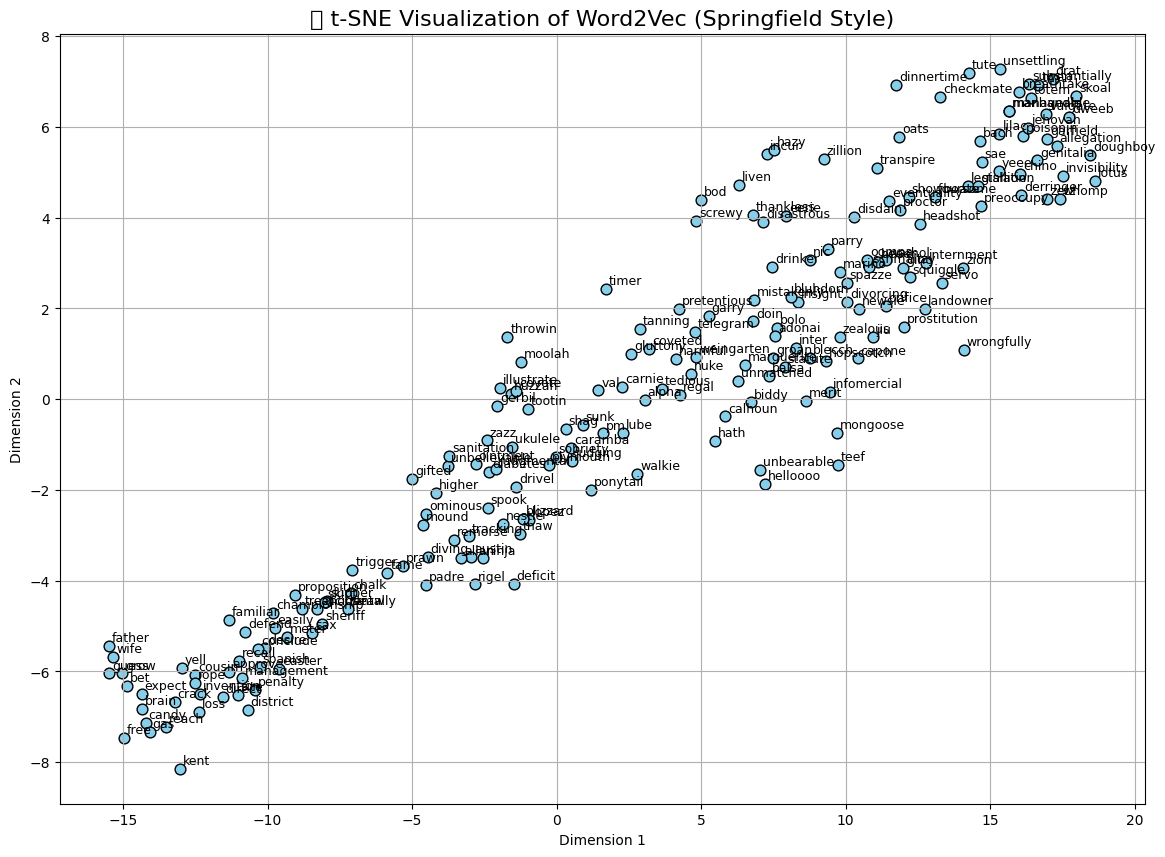

In [13]:
# 🧠 Clustering the Springfield Vocabulary with t-SNE

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import random

# Sample a subset of vocabulary for visualization
words = list(w2v_model.wv.key_to_index.keys())
random_words = random.sample(words, 200)

# Get vectors and convert to NumPy array
word_vectors = np.array([w2v_model.wv[word] for word in random_words])

# t-SNE dimensionality reduction
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
word_vecs_2d = tsne.fit_transform(word_vectors)

# Plotting the clusters
plt.figure(figsize=(14, 10))
plt.scatter(word_vecs_2d[:, 0], word_vecs_2d[:, 1], edgecolors='k', c='skyblue', s=60)

# Annotate each point with its word
for i, word in enumerate(random_words):
    plt.text(word_vecs_2d[i, 0]+0.1, word_vecs_2d[i, 1]+0.1, word, fontsize=9)

plt.title("🧠 t-SNE Visualization of Word2Vec (Springfield Style)", fontsize=16)
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.savefig("plots/simpsons_word2vec_tsne.png", dpi=300, bbox_inches='tight')
plt.show()


## 7. Coloring Springfield: t-SNE + KMeans Clustering

Let’s add some structure to our semantic map of Springfield! In this cell, we enhance the t-SNE visualization by applying **KMeans clustering** to group similar words into mini-clusters.

**What’s Happening**
- We apply KMeans to the 2D t-SNE output to identify 8 distinct clusters.
- Each word is colored based on its cluster assignment.
- The result is a more interpretable plot that reveals hidden themes and relationships.

Clustering helps us spot patterns in the vocabulary, maybe one group contains food-related words, another emotional expressions, and another character names. It’s a great way to explore how the Word2Vec model organizes Springfield’s linguistic landscape.

> Try experimenting with different values of `n_clusters` to see how the groupings change!

Now we’re not just visualizing Springfield; we’re decoding its dialects.


/tmp/ipykernel_513808/3623437036.py:21: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.savefig("plots/simpsons_word2vec_tsne_kmeans.png", dpi=300, bbox_inches='tight')
/home/khalaji/Coding/medium-posts/word2vec-springfield-lab/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


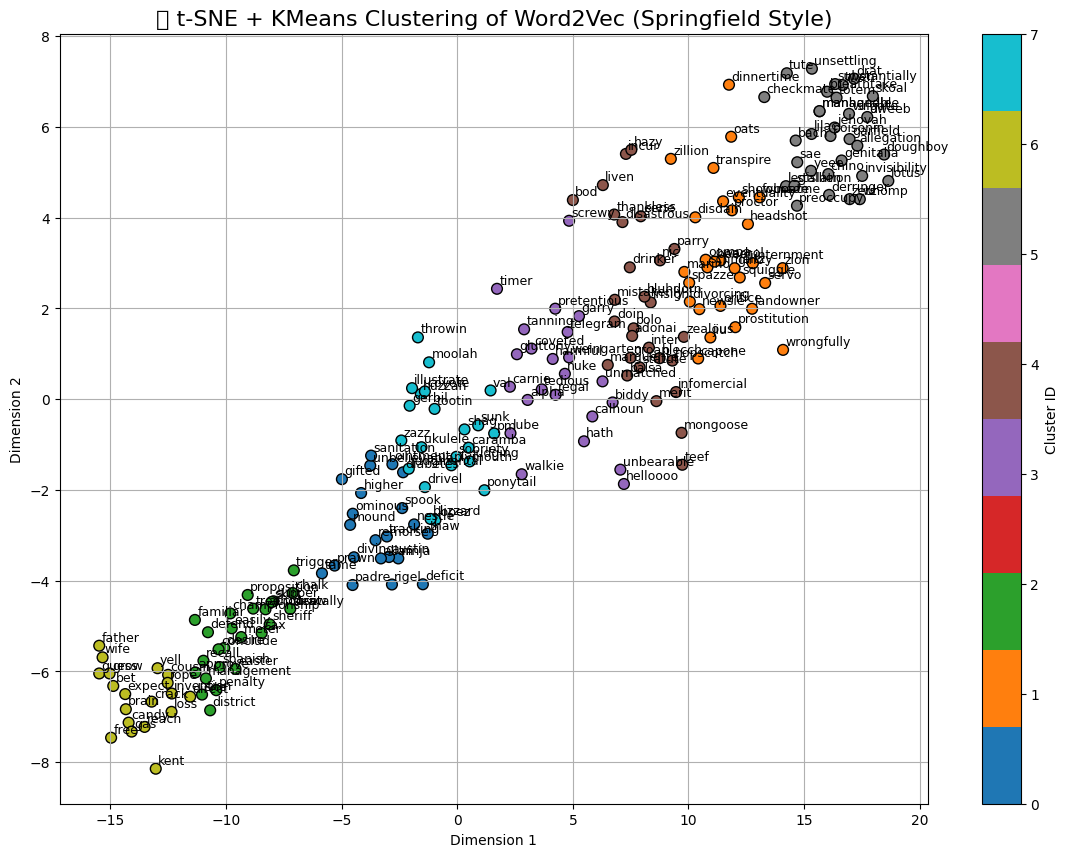

In [15]:
# Optional: Color by mini-clusters using KMeans
from sklearn.cluster import KMeans

# Choose number of clusters (e.g., 8)
kmeans = KMeans(n_clusters=8, random_state=42)
labels = kmeans.fit_predict(word_vecs_2d)

# Plot with cluster colors
plt.figure(figsize=(14, 10))
scatter = plt.scatter(word_vecs_2d[:, 0], word_vecs_2d[:, 1], c=labels, cmap='tab10', s=60, edgecolors='k')

# Annotate each word
for i, word in enumerate(random_words):
    plt.text(word_vecs_2d[i, 0]+0.1, word_vecs_2d[i, 1]+0.1, word, fontsize=9)

plt.title("🧠 t-SNE + KMeans Clustering of Word2Vec (Springfield Style)", fontsize=16)
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.colorbar(scatter, label='Cluster ID')
plt.savefig("plots/simpsons_word2vec_tsne_kmeans.png", dpi=300, bbox_inches='tight')
plt.show()


## Final Reflections

This notebook explored the linguistic patterns of The Simpsons using Word2Vec, a model that learns the meaning of words by analyzing the context in which they appear. By training the model on character dialogue, we allowed it to capture the relationships between words based on how they are used together. This approach does not rely on predefined rules but instead builds meaning from patterns in the data.

Once the model was trained, we sampled a portion of its vocabulary and used t-SNE to reduce the dimensionality of the word vectors. This gave us a visual representation of how words are positioned in the learned semantic space. We then applied KMeans clustering to group similar words, which helped reveal thematic clusters and made the structure of the vocabulary easier to interpret.

The real strength of Word2Vec lies in its ability to represent words as vectors that reflect both meaning and usage. These embeddings can be used to compare words, find analogies, and analyze character-specific language. They also provide a foundation for more advanced tasks such as dialogue generation, sentiment analysis, or tracking changes in vocabulary over time.

Through this project, we have seen how Word2Vec can turn raw dialogue into a structured map of meaning. It offers a way to quantify language and uncover hidden relationships within a fictional world. Even in a town as unpredictable as Springfield, Word2Vec helps us find order in the chaos and understand how words reflect personality, emotion, and culture.
